In [1]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [3]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JV4N8",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
    "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
)

In [4]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("../data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        self._price = df_price.sort_index(level="date")

        self._dur = pd.read_csv("../data/bond_data_duration.csv", parse_dates=["date"])
        self._dur["date"] = self._dur["date"].dt.date
        self._dur = self._dur.set_index(["date", "isin"]).sort_index(level="date")

        self._static = pd.read_csv("../data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "../data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date

        self._volume = pd.read_csv("../data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("../data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("../data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")

    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]


bond_data = BondDataProvider()

In [5]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

In [6]:
# create portfolio for a simple strategy
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

## Random Weights Strategy

In [7]:
%% time
start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
day_ = pd.Timedelta(days=1)

dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)
    a = (np.random.uniform(-1, 1, port.universe_size) + 1) / 2

    price_today = bond_data.price.loc[
        pd.IndexSlice[slice(date, date), port.bond_universe], :
    ]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    new_weights = a / a.sum(axis=0, keepdims=1)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today
    print(new_weights - port.weights)
    cash = wealth - qty @ price_today
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
[0.25112467 0.19126321 0.04872459 0.11732368 0.1478214  0.11354355
 0.1301989 ]
2023-08-02
wealth = 0.9986551488434741
[-0.14571826 -0.00306256  0.01813222  0.10535138 -0.08463058 -0.04123371
  0.15116152]
2023-08-03
wealth = 0.9978886699848527
[ 0.09601089 -0.00619232  0.02685956 -0.01873116  0.0783282   0.01722567
 -0.19350085]
2023-08-04
wealth = 0.9983571130703564
[-0.10585415 -0.08662055  0.11042781 -0.08098937 -0.0065202   0.12680474
  0.04275172]
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9951337878595059
[ 0.19267984 -0.03832929 -0.12008687  0.05417304  0.00878211 -0.06709895
 -0.03011988]
2023-08-08
wealth = 0.9959847603171506
[-0.09438127  0.16817021 -0.02672607  0.21239959 -0.13411455 -0.05289971
 -0.07244819]
2023-08-09
wealth = 0.9971738946071987
[ 0.03889461 -0.11577007  0.03904896 -0.23136944  0.04328035 -0.02765432
  0.25356991]
2023-08-10
wealth = 0.9989121925120013
[-0.1382734   0.06395163  0.01616744  0.00846159  0.06237253  0.09176909
 -0.10

### Random Weights Strategy Results

In [ ]:
wealth

## Sharpe Ratio Strategy

basic statistic to optimize in a portfolio.
it compares the return of an investment with its risk, so it seeks to pick find an offset between high yield and low risk

In [13]:
# df with "dur_mod", "yield", "shape" field for each day and each bond
sharpe_data = (
    bond_data.duration.groupby(["date", "isin"])
    .dur_mod.mean()
    .to_frame()
    .loc[(slice(None), BOND_UNIVERSE), ["dur_mod"]]
    .fillna(float("inf"))
    .join(
        bond_data.yield_.set_index(["date", "isin"]).loc[
            (slice(None), BOND_UNIVERSE), ["yield"]
        ],
    )
)

sharpe_data["sharpe"] = sharpe_data["yield"] / sharpe_data["dur_mod"]
sharpe_data = sharpe_data.sort_index()

In [14]:
sharpe_data_sorted = sharpe_data.loc[date].sort_values(
    "sharpe", ascending=False
)
sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
sharpe_data_sorted["weight"] = (
    sharpe_data_sorted["sharpe_squared"]
    / sharpe_data_sorted["sharpe_squared"].sum()
)
sharpe_data_sorted
# select max sharp
# weights = (
#     sharpe_data_sorted.loc[(slice(None), universe), :]

,dur_mod,yield,sharpe,sharpe_squared,weight
isin,,,,,
RU000A0JUMH3,0.588109,0.115846,0.196981,0.038802,0.651056
RU000A0JVA10,1.177732,0.132693,0.112669,0.012694,0.212997
RU000A0JW0S4,1.855754,0.127511,0.068711,0.004721,0.079218
RU000A0JWDN6,2.274082,0.118546,0.052129,0.002717,0.045596
RU000A0GN9A7,6.657464,0.115169,0.017299,0.000299,0.005021
RU000A0JV4N8,5.636553,0.081891,0.014529,0.000211,0.003542
RU000A0JV4Q1,6.702876,0.082937,0.012373,0.000153,0.002569


In [15]:
sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )

dur_mod     yield    sharpe
date       isin                                      
2023-09-20 RU000A0JUMH3  0.588109  0.115846  0.196981
           RU000A0JVA10  1.177732  0.132693  0.112669
           RU000A0JW0S4  1.855754  0.127511  0.068711
           RU000A0JWDN6  2.274082  0.118546  0.052129
           RU000A0GN9A7  6.657464  0.115169  0.017299
           RU000A0JV4N8  5.636553  0.081891  0.014529
           RU000A0JV4Q1  6.702876  0.082937  0.012373

In [16]:
port = BondPortfolio(
    cash=1,
    bond_universe=BOND_UNIVERSE,
)

In [17]:
def get_weights(date: datetime.date, universe: tuple[str]):
    """Get target weights based on sharpe ratio."""
    sharpe_data_sorted = sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )
    sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
    sharpe_data_sorted["weight"] = (
        sharpe_data_sorted["sharpe_squared"]
        / sharpe_data_sorted["sharpe_squared"].sum()
    )

    # select max sharp
    weights = (
        sharpe_data_sorted.loc[(slice(None), universe), :]
        .reset_index()["weight"]
        .fillna(0)
        .values
    )
    assert len(weights) == len(universe), f"{len(weights)},  {len(universe)}"
    return weights

In [18]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    new_weights = get_weights(date, BOND_UNIVERSE)  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = -2.220446049250313e-16
2023-08-02
wealth = 0.999877605997308
cash = 0.0
2023-08-03
wealth = 0.997852737113143
cash = 2.220446049250313e-16
2023-08-04
wealth = 0.9979638505969904
cash = 1.1102230246251565e-16
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9964516162626471
cash = 1.1102230246251565e-16
2023-08-08
wealth = 0.9968897272080548
cash = 4.440892098500626e-16
2023-08-09
wealth = 0.9952035884008431
cash = -1.1102230246251565e-16
2023-08-10
wealth = 0.9989990726492806
cash = 0.0
2023-08-11
wealth = 0.9959058195303009
cash = 1.1102230246251565e-16
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9964227757856775
cash = 0.0
2023-08-15
wealth = 0.9859243737486095
cash = 0.0
2023-08-16
wealth = 0.9928902742058036
cash = 0.0
2023-08-17
wealth = 0.9896478701483994
cash = -1.1102230246251565e-16
2023-08-18
wealth = 0.9898619585040244
cash = -1.1102230246251565e-16
2023-08-19
2023-08-20
2023-08-21
wealth = 0.9945369243255121
cash = 1.1102230246251565e-16
2023-08-22

### Sharpe Ratio Strategy Results

In [19]:
wealth

0.980494031477722

## Quadratic optimization

In [20]:
%% time

from baseline.quadratic import get_optimal_weights

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )
    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()

    today_info = today_info.join(rating_reduced)
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    #
    # make predictions
    #
    new_weights = get_optimal_weights(
        bond_data=today_info,
        upper_bound=0.5,
        value_date=date,
        maturity_limit=10,
    )  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 0.9951634073517563
cash = -1.3007372956508334e-12
2023-08-02
wealth = 0.9951671751216257
cash = -1.3007372956508334e-12
2023-08-03
wealth = 0.9915068530677772
cash = -1.2959633366449452e-12
2023-08-04
wealth = 0.9847738976164745
cash = -1.2871925747504065e-12
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9826982288328323
cash = -1.2844170171888436e-12
2023-08-08
wealth = 0.9814615509926463
cash = -1.2826406603494434e-12
2023-08-09
wealth = 0.9827214327147379
cash = -1.2844170171888436e-12
2023-08-10
wealth = 0.9826689628691389
cash = -1.2844170171888436e-12
2023-08-11
wealth = 0.9792456659112622
cash = -1.2798651027878805e-12
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9779777486016341
cash = -1.2783107905534052e-12
2023-08-15
wealth = 0.975440532127867
cash = -1.2748690991770673e-12
2023-08-16
wealth = 0.976509397466962
cash = -1.27631238910908e-12
2023-08-17
wealth = 0.9754593587571385
cash = -1.2749801214795298e-12
2023-08-18
wealth = 0.977848255922246
cash = -1.27

In [21]:
wealth

0.9589643043212827

# Basic analytics

In [22]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [23]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

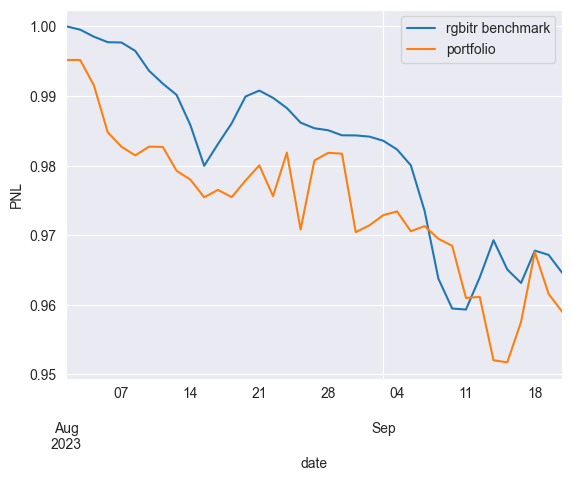

In [24]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")

plt.legend()
plt.ylabel("PNL");

### mean and median return

In [25]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

'Mean return = -0.001, Median return = -0.001'

## Sharpe Ratio

In [26]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [27]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

1.53600326463795e-98

### Information Ratio

In [28]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [29]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

0.0035176129885404134

## Returns

/var/folders/9w/txlxlj150xxgp7zy568gnwjn7lbpgp/T/ipykernel_98213/921857431.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
/var/folders/9w/txlxlj150xxgp7zy568gnwjn7lbpgp/T/ipykernel_98213/921857431.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

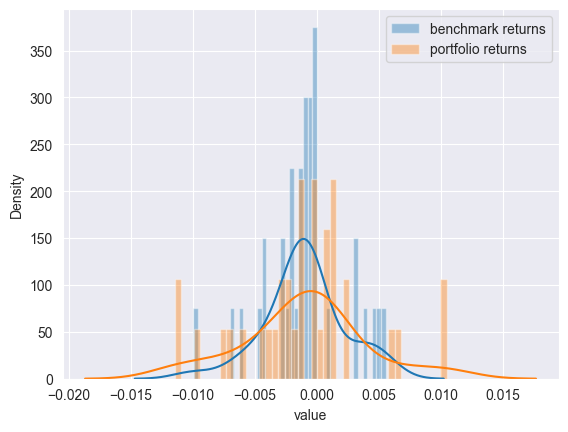

In [30]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

/var/folders/9w/txlxlj150xxgp7zy568gnwjn7lbpgp/T/ipykernel_98213/3621973020.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns_diff, bins=42, label="portfolio returns");


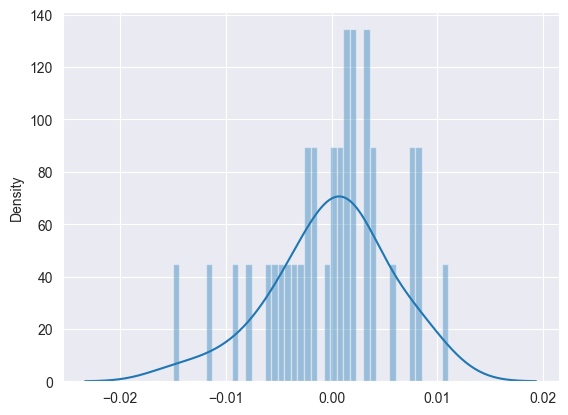

In [31]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [32]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

TtestResult(statistic=-0.021105677931242302, pvalue=0.9832812222909604, df=35)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [33]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

const   -0.001457
beta    -0.073636
gamma    0.504815
dtype: float64

## Value at Risk

In [34]:
alpha = 0.05
returns_benchmark.quantile(alpha)

-0.006116591003621885

## Skewness of Returns

In [35]:
alpha = 0.05
returns_benchmark.skew()

-0.20963976217357644